/tmp/ipykernel_32754/1502410250.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('Reds')


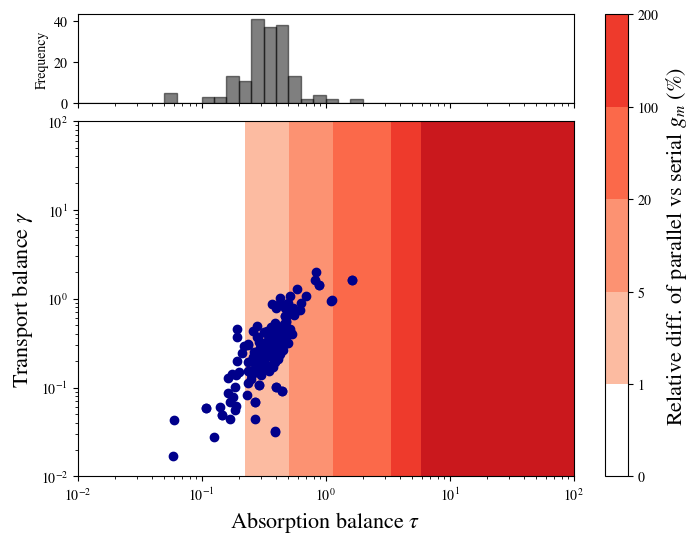

Tau value where relative difference exceeds 5%: 0.58
Fraction of data with tau greater than this value: 6.90%


In [2]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pandas as pd 
from matplotlib.ticker import FormatStrFormatter, NullFormatter


#set font
mpl.rcParams['mathtext.fontset'] = 'stix'  # or 'dejavusans', 'cm', 'custom'
mpl.rcParams['font.family'] = 'STIXGeneral'  # Matches STIX math font
# create discrete colormap of size N=6 from 'Blues' colormap
cmap = mpl.cm.get_cmap('Reds')
# get a list of colors from the colormap
colors = [cmap(i) for i in range(cmap.N)]
# create a new colormap from a subset of colors
cmap = mpl.colors.ListedColormap(colors[32::32])
# force the first color to be white
cmap.colors[0] = (1, 1, 1, 1)
# define the bounds and normalize
bounds = [0, 1, 5, 20, 100, 200]
norm = mpl.colors.BoundaryNorm(bounds, 5)


# This script compares the serial and parallel mesophyll conductance models
# and plots the relative difference in mesophyll conductance as a function of the absorption balance tau
taus = np.exp(np.linspace(np.log(0.01), np.log(100), 35))
gmgc_0D = 1/(1+0.5*(taus)**2) # serial (0D) mesophyll conductance
gmgc_1D = 1/(taus)*np.tanh(taus) # parallel (1D) mesophyll conductance
diff = 100*np.abs(gmgc_1D - gmgc_0D)/gmgc_0D # relative difference
# diff = np.array([d if d > 0.01 else 0 for d in diff])

diffs = [diff for _ in taus]

# do a histogram of the tau distribution in data provided by Knauer et al. 2022
dfKnauer = pd.read_csv('../../data/saved_data/Knauer2022_hypostomatous.csv', sep=';', decimal=',')
taus_data = dfKnauer['tau'].to_numpy()
gammas_data = dfKnauer['gamma'].to_numpy()

fig, (ax_hist, ax) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={'height_ratios': [1, 4], 'hspace': 0.08},
    figsize=(8, 6)
)

heatmap = ax.pcolor(taus, taus, diffs, cmap=cmap, norm=norm)
colorbar = plt.colorbar(heatmap, ax=[ax_hist,ax])
colorbar.set_label(r'Relative diff. of parallel vs serial $g_m$ (%)', fontsize=16)
ax.scatter(taus_data, gammas_data, color='darkblue', marker='o', label='Knauer et al. 2022 data')

# top: (cumulative) histogram of taus_data
bins = np.logspace(np.log10(0.01), np.log10(100), 41)
weights = np.ones_like(taus_data) #/ len(taus_data) * 100 # normalize if you want percentages
ax_hist.hist(
    taus_data,
    bins=bins,
    range=(0.01, 100),
    weights=weights,
    cumulative=False,    # set true if you want cumulative histogram
    histtype='bar',
    color='black',
    edgecolor='black',
    alpha=0.5,
)
ax_hist.set_xscale('log')
# ax_hist.set_yscale('log') # log scale if cumulative
ax_hist.set_ylabel('Frequency', fontsize=10)
ax_hist.tick_params(labelbottom=False)  # hide x labels on the top axes
ax_hist.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # '%.0f%%' if attached % signs
ax_hist.yaxis.set_minor_formatter(NullFormatter())


ax.set_xlim(0.01, 100)
ax.set_ylim(0.01, 100)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Absorption balance $\tau$', fontsize=16)
ax.set_ylabel(r'Transport balance $\gamma$', fontsize=16)
plt.savefig('../vectorgraphics/figure3gm_2.svg')
plt.show()

mask = diff < 5
# find index of first false
index = np.argmax(~mask)
tau_5perc = taus[index]
print(f'Tau value where relative difference exceeds 5%: {tau_5perc:.2f}')
print(f"Fraction of data with tau greater than this value: {np.sum(taus_data > tau_5perc) / len(taus_data) * 100:.2f}%")